In [ ]:
%%python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
%%python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import json
import shutil
import os
import glob
print_config()


MONAI version: 0.9.dev2222
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: e01f7dbe188af1ea75d656c0f07f78fff494c2ca
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
directory = 'content/task'
root_dir = tempfile.mkdtemp() if directory is None else directory
task = 'Task09_Spleen'
taskNumber = task[4:6]

content/task


In [ ]:
resource = {
    "Task01_BrainTumour": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar",
    "Task02_Heart": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar",
    "Task03_Liver": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar",
    "Task04_Hippocampus": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar",
    "Task05_Prostate": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar",
    "Task06_Lung": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar",
    "Task07_Pancreas": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar",
    "Task08_HepaticVessel": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task08_HepaticVessel.tar",
    "Task09_Spleen": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar",
    "Task10_Colon": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task10_Colon.tar"
}
md5 = {
    "Task01_BrainTumour": "240a19d752f0d9e9101544901065d872",
    "Task02_Heart": "06ee59366e1e5124267b774dbd654057",
    "Task03_Liver": "a90ec6c4aa7f6a3d087205e23d4e6397",
    "Task04_Hippocampus": "9d24dba78a72977dbd1d2e110310f31b",
    "Task05_Prostate": "35138f08b1efaef89d7424d2bcc928db",
    "Task06_Lung": "8afd997733c7fc0432f71255ba4e52dc",
    "Task07_Pancreas": "4f7080cfca169fa8066d17ce6eb061e4",
    "Task08_HepaticVessel": "641d79e80ec66453921d997fbf12a29c",
    "Task09_Spleen": "410d4a301da4e5b2f6f86ec3ddba524e",
    "Task10_Colon": "bad7a188931dc2f6acf72b08eb6202d0"
}
def data(task):  
    
    
    res = resource[task]
    resVal = md5[task]

    taskTar = task + ".tar"
    compressed_file = os.path.join(root_dir, taskTar)
    data_dir = os.path.join(root_dir, task)
    if not os.path.exists(data_dir):
        download_and_extract(res, compressed_file, root_dir, resVal)

    train_images = sorted(
        glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
    valSplit = len(data_dicts)//5
    train_files, val_files = data_dicts[:-valSplit], data_dicts[-valSplit:]

    return train_files, val_files

tf, vf = data(task)

In [ ]:
print(len(vf), len(tf))
check_ds = Dataset(data=vf, transform=Compose([LoadImaged(keys=["image", "label"]),EnsureChannelFirstd(keys=["image", "label"]),EnsureTyped(keys=["image", "label"])]))
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
check_data["image"][0][0].shape, check_data["label"][0][0].shape

for d in check_loader:
    print(d["image"][0][0].shape)

9 32
torch.Size([512, 512, 33])
torch.Size([512, 512, 50])
torch.Size([512, 512, 135])
torch.Size([512, 512, 97])
torch.Size([512, 512, 101])
torch.Size([512, 512, 80])
torch.Size([512, 512, 60])
torch.Size([512, 512, 31])
torch.Size([512, 512, 41])


In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        #Resized(keys=["image", "label"], spatial_size=(160,140,120)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #Resized(keys=["image", "label"], spatial_size=(160,140,120)),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


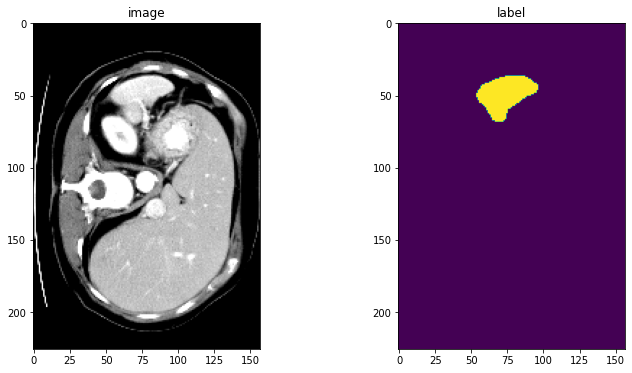

In [ ]:
check_ds = Dataset(data=vf, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [ ]:
train_ds = CacheDataset(
    data=tf, transform=train_transforms, cache_rate=1.0, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=False, num_workers=4)

val_ds = CacheDataset(
    data=vf, transform=val_transforms, cache_rate=1.0, num_workers=2)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

Streaming output truncated to the last 5000 lines.
12/16, train_loss: 0.2944
13/16, train_loss: 0.3463
14/16, train_loss: 0.2942
15/16, train_loss: 0.2908
16/16, train_loss: 0.2402
epoch 51 average loss: 0.2661
----------
epoch 52/300
1/16, train_loss: 0.2131
2/16, train_loss: 0.1756
3/16, train_loss: 0.2852
4/16, train_loss: 0.1862
5/16, train_loss: 0.1621
6/16, train_loss: 0.2370
7/16, train_loss: 0.2010
8/16, train_loss: 0.2472
9/16, train_loss: 0.2351
10/16, train_loss: 0.2361
11/16, train_loss: 0.2308
12/16, train_loss: 0.1520
13/16, train_loss: 0.2017
14/16, train_loss: 0.1944
15/16, train_loss: 0.2636
16/16, train_loss: 0.4542
epoch 52 average loss: 0.2297
current epoch: 52 current mean dice: 0.8245
best mean dice: 0.8546 at epoch: 46
----------
epoch 53/300
1/16, train_loss: 0.1723
2/16, train_loss: 0.3370
3/16, train_loss: 0.2202
4/16, train_loss: 0.2715
5/16, train_loss: 0.2813
6/16, train_loss: 0.1349
7/16, train_loss: 0.3118
8/16, train_loss: 0.2719
9/16, train_loss: 0.1907

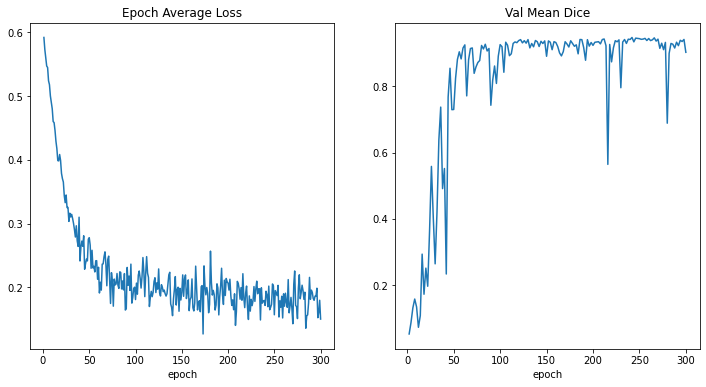

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

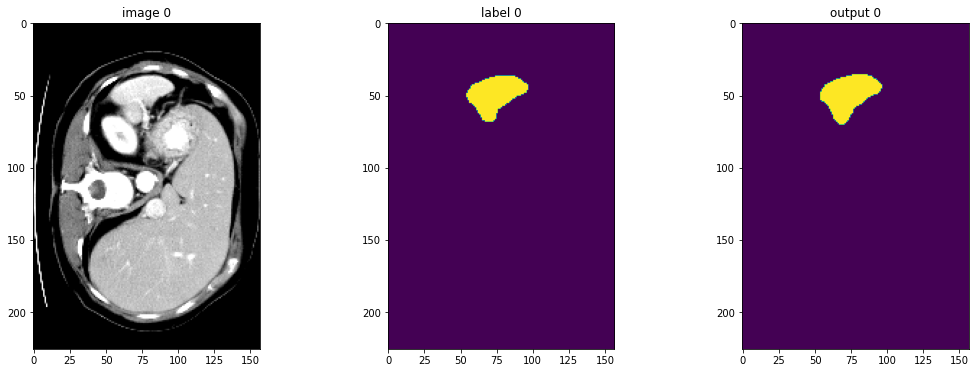

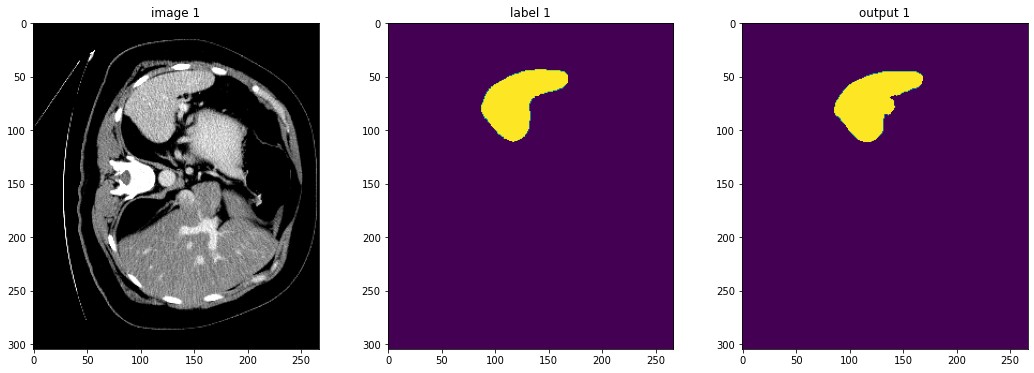

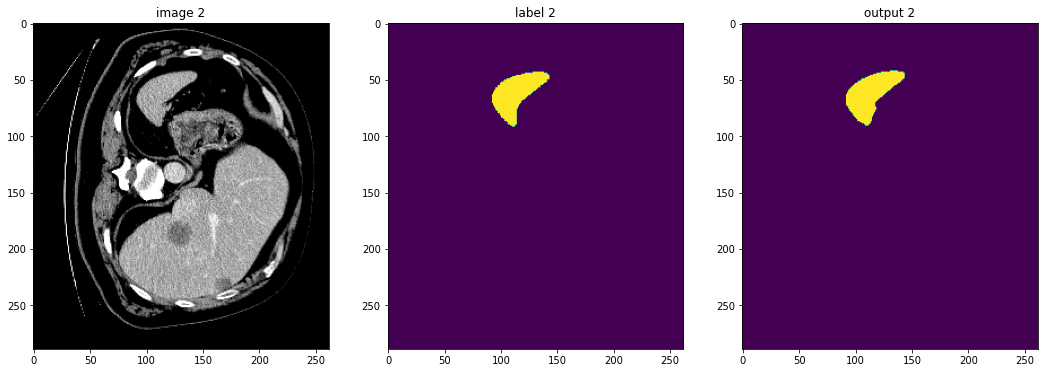

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=vf, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9602856040000916


In [ ]:
data_dir = os.path.join(root_dir, task)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

print(test_images)

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=2)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

['content/task/Task09_Spleen/imagesTs/spleen_1.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_11.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_15.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_23.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_30.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_34.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_35.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_36.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_37.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_39.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_42.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_43.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_48.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_50.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_51.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_54.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_55.nii.gz', 'content/task/Task09_Spleen/imagesTs/spleen_57.n

In [ ]:
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
%matplotlib inline

2022-06-04 01:52:53,202 INFO image_writer.py:190 - writing: out/spleen_1/spleen_1_seg.nii.gz


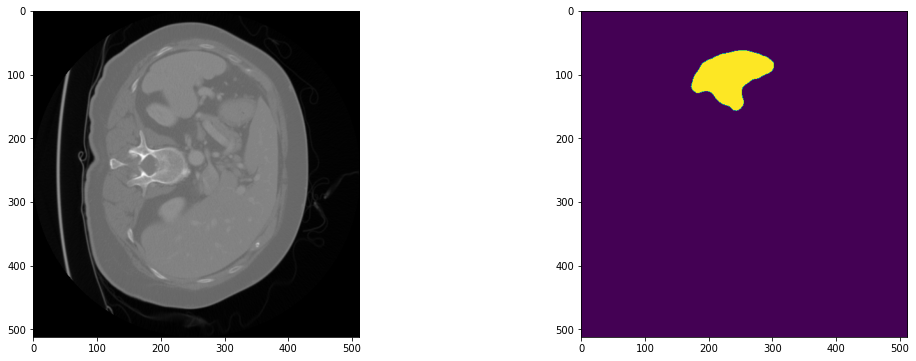

2022-06-04 01:53:07,555 INFO image_writer.py:190 - writing: out/spleen_11/spleen_11_seg.nii.gz


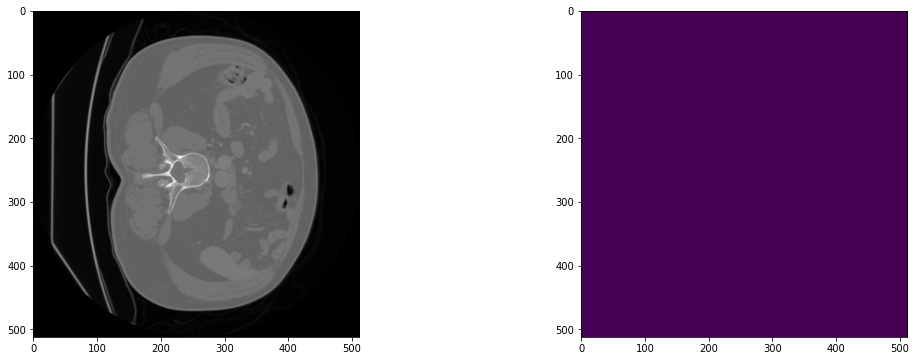

2022-06-04 01:53:14,892 INFO image_writer.py:190 - writing: out/spleen_15/spleen_15_seg.nii.gz


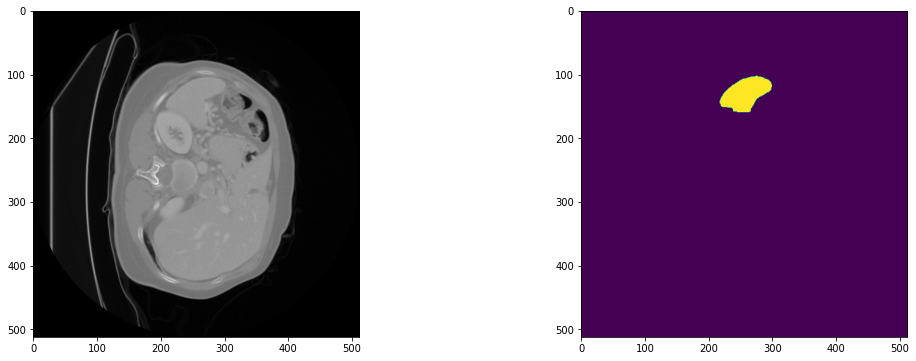

2022-06-04 01:53:23,476 INFO image_writer.py:190 - writing: out/spleen_23/spleen_23_seg.nii.gz


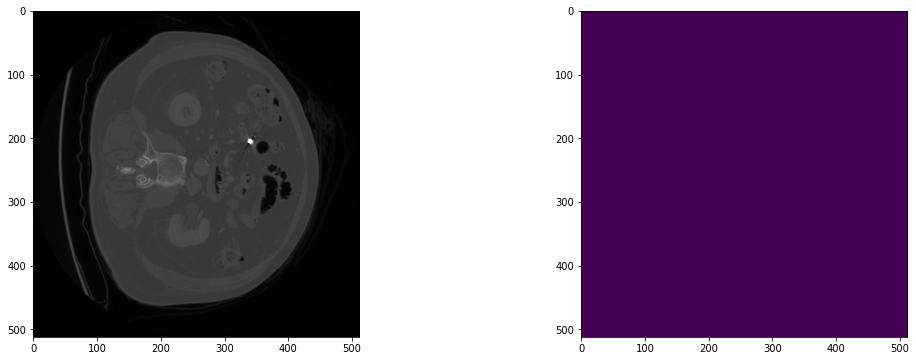

2022-06-04 01:53:33,691 INFO image_writer.py:190 - writing: out/spleen_30/spleen_30_seg.nii.gz


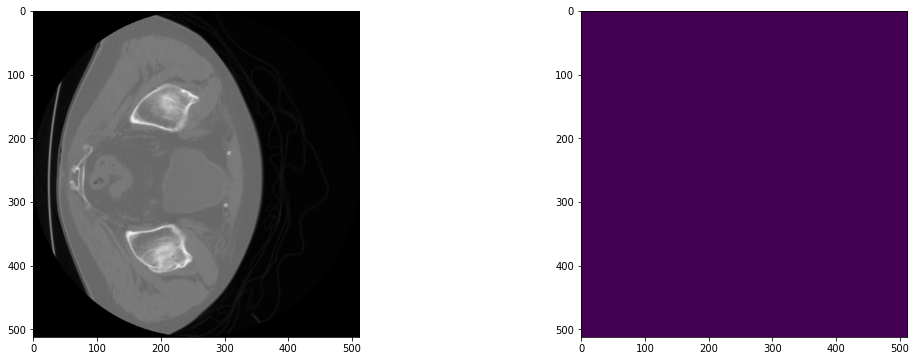

2022-06-04 01:53:40,618 INFO image_writer.py:190 - writing: out/spleen_34/spleen_34_seg.nii.gz


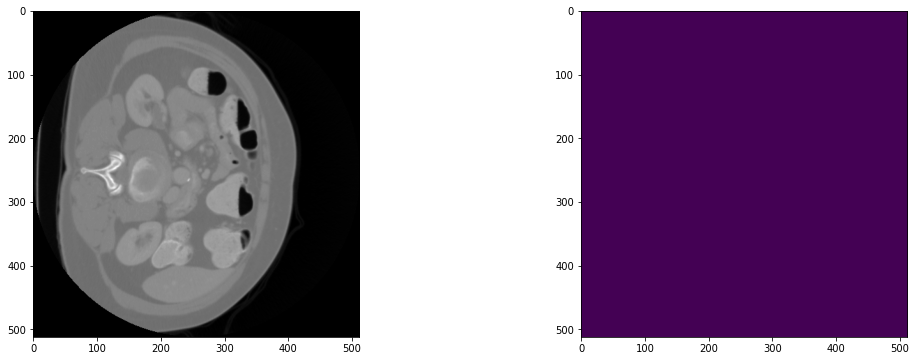

2022-06-04 01:53:46,211 INFO image_writer.py:190 - writing: out/spleen_35/spleen_35_seg.nii.gz


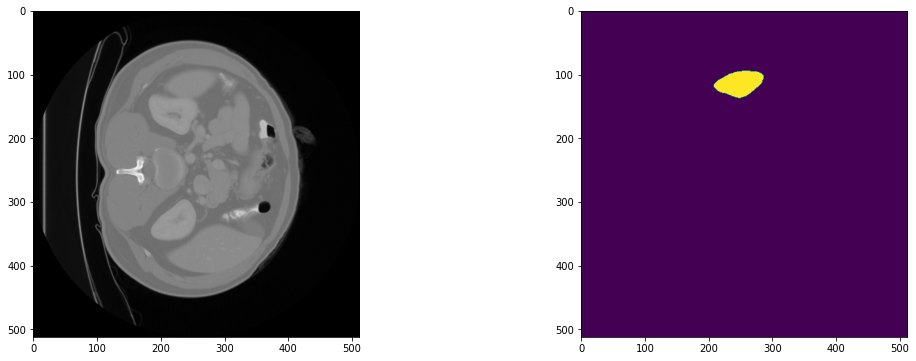

2022-06-04 01:53:55,201 INFO image_writer.py:190 - writing: out/spleen_36/spleen_36_seg.nii.gz


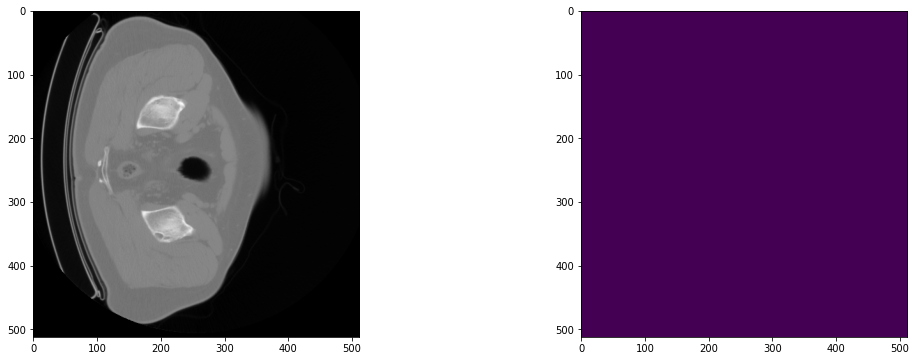

2022-06-04 01:54:07,806 INFO image_writer.py:190 - writing: out/spleen_37/spleen_37_seg.nii.gz


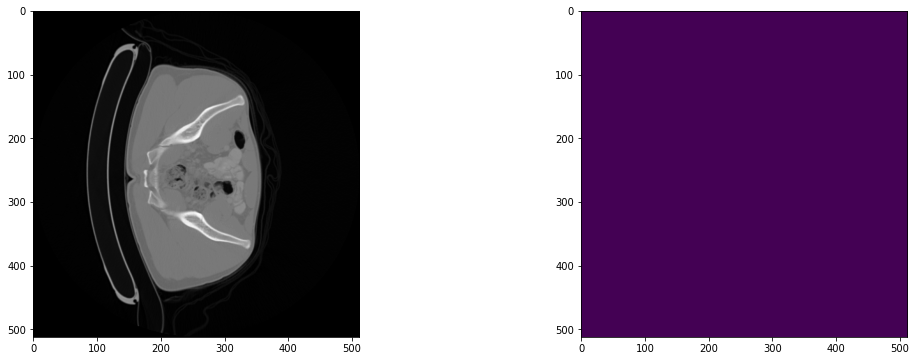

2022-06-04 01:54:17,993 INFO image_writer.py:190 - writing: out/spleen_39/spleen_39_seg.nii.gz


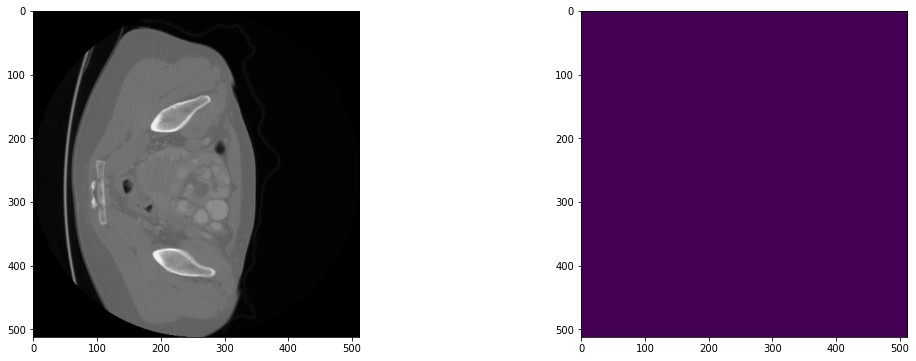

2022-06-04 01:54:26,956 INFO image_writer.py:190 - writing: out/spleen_42/spleen_42_seg.nii.gz


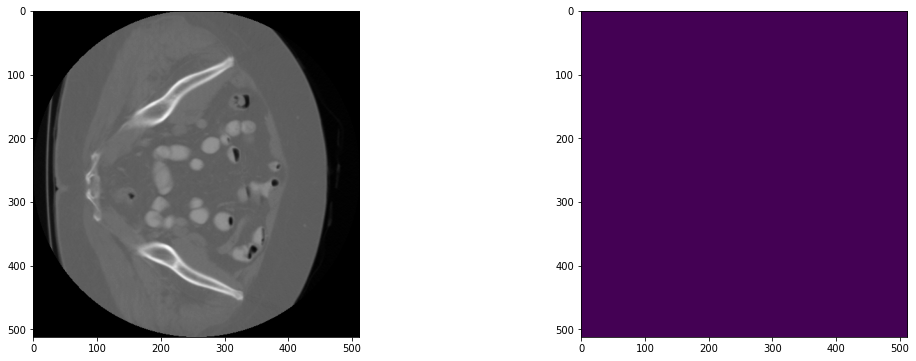

2022-06-04 01:54:37,372 INFO image_writer.py:190 - writing: out/spleen_43/spleen_43_seg.nii.gz


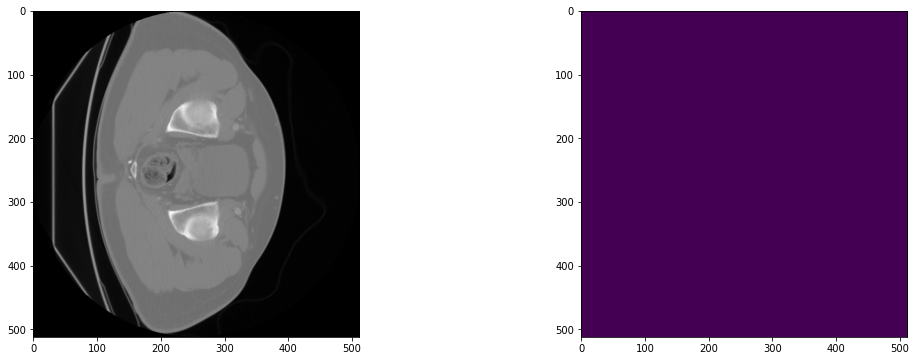

2022-06-04 01:54:47,602 INFO image_writer.py:190 - writing: out/spleen_48/spleen_48_seg.nii.gz


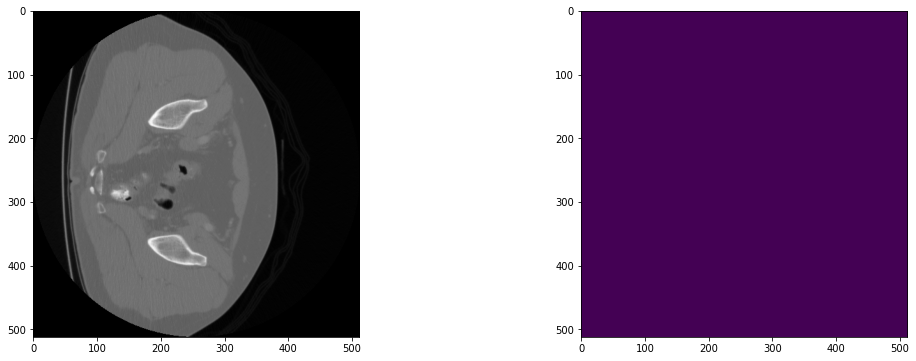

2022-06-04 01:54:53,275 INFO image_writer.py:190 - writing: out/spleen_50/spleen_50_seg.nii.gz


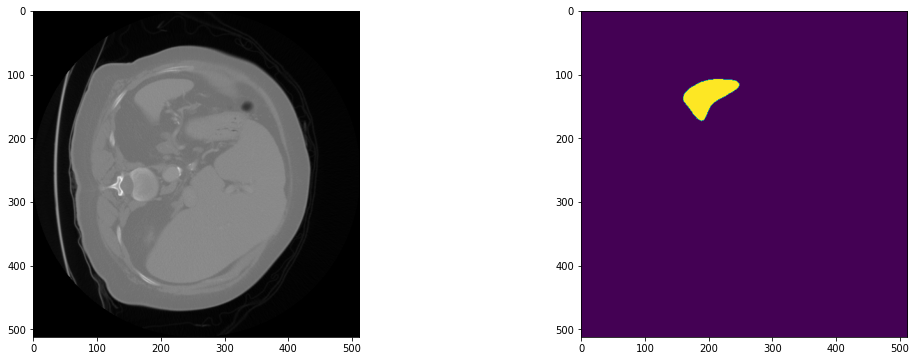

2022-06-04 01:55:01,837 INFO image_writer.py:190 - writing: out/spleen_51/spleen_51_seg.nii.gz


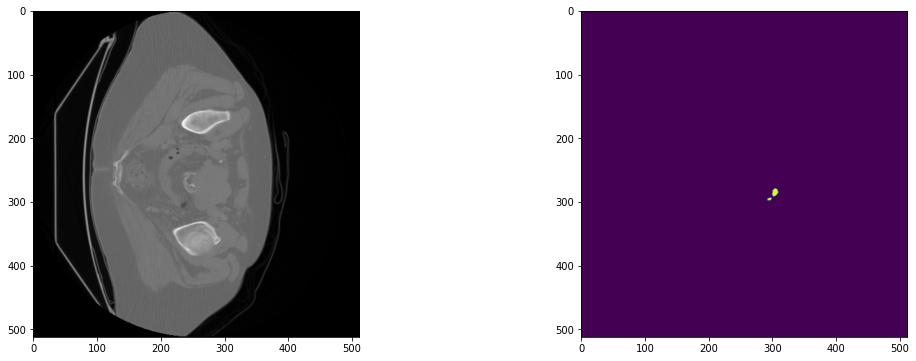

2022-06-04 01:55:11,568 INFO image_writer.py:190 - writing: out/spleen_54/spleen_54_seg.nii.gz


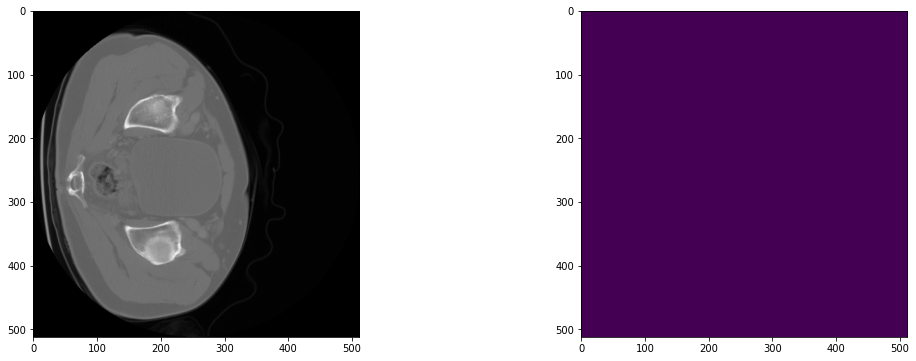

2022-06-04 01:55:19,829 INFO image_writer.py:190 - writing: out/spleen_55/spleen_55_seg.nii.gz


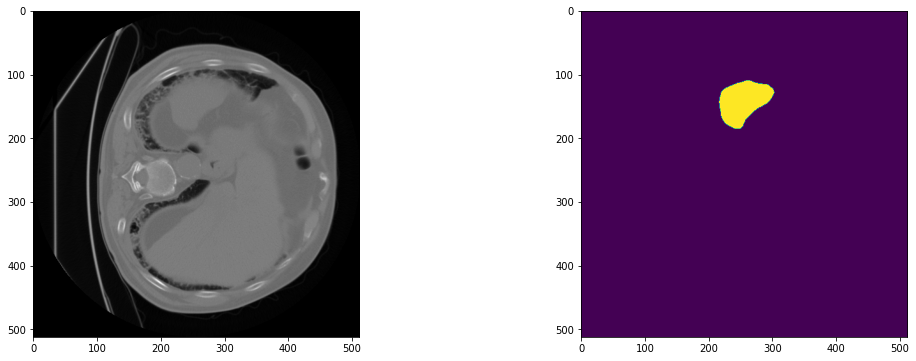

2022-06-04 01:55:25,391 INFO image_writer.py:190 - writing: out/spleen_57/spleen_57_seg.nii.gz


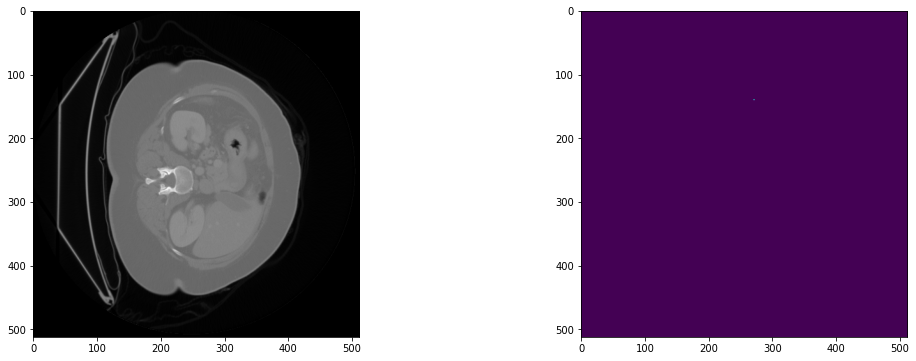

2022-06-04 01:55:30,262 INFO image_writer.py:190 - writing: out/spleen_58/spleen_58_seg.nii.gz


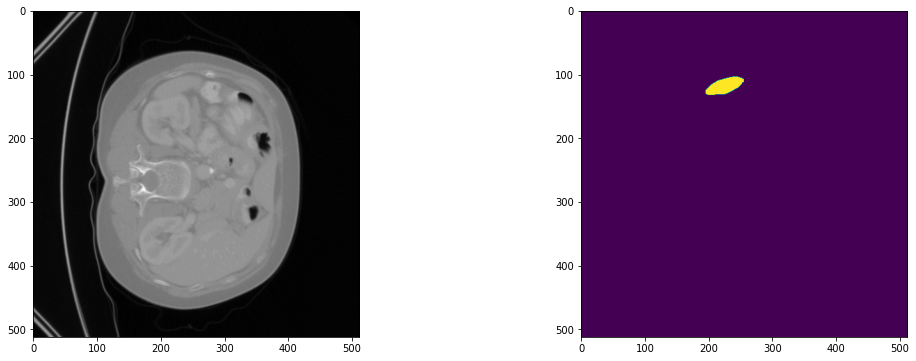

2022-06-04 01:55:39,860 INFO image_writer.py:190 - writing: out/spleen_7/spleen_7_seg.nii.gz


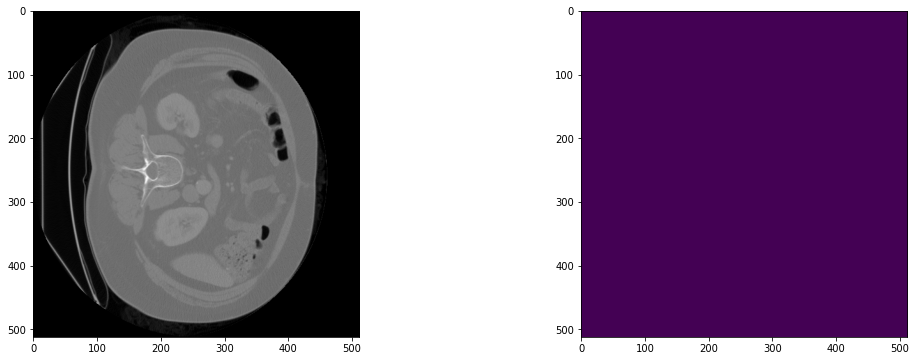

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        test_output = from_engine(["pred"])(test_data)
        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()


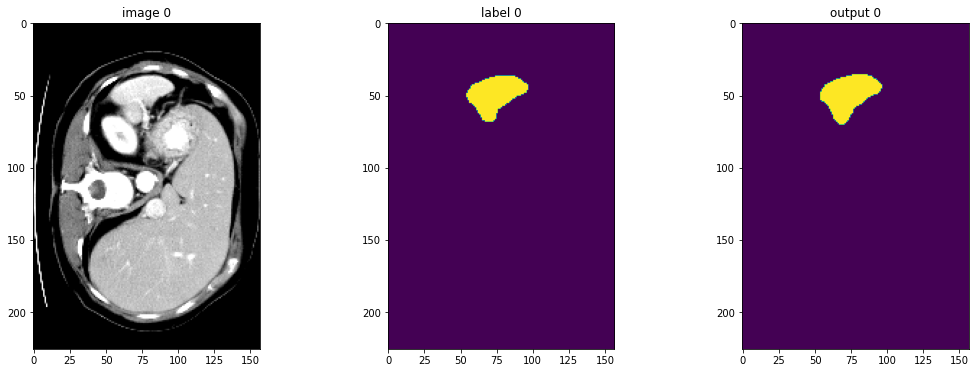

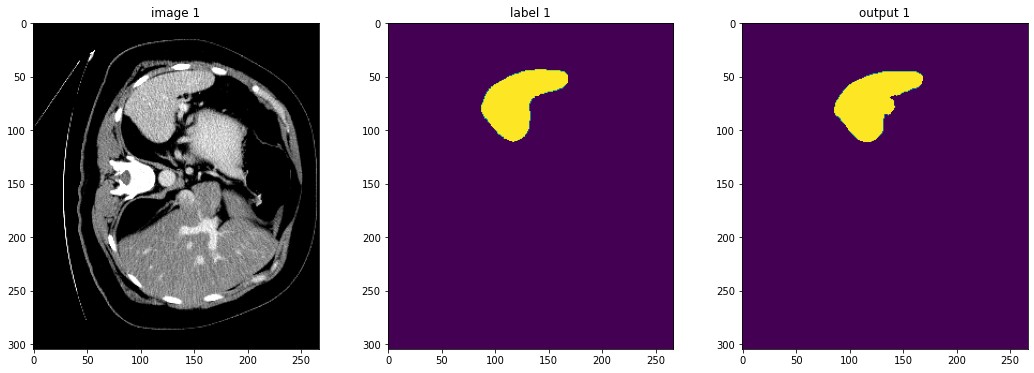

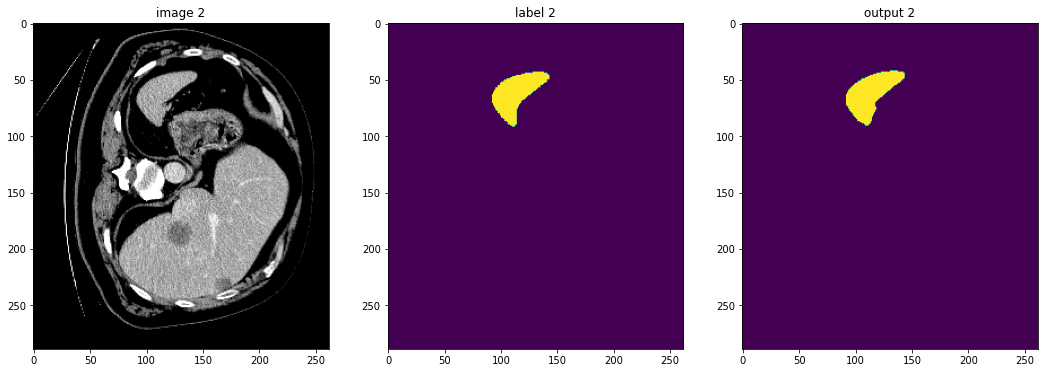

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)